# Hartree-Fock approximation

In [38]:
import numpy as np
from numpy.linalg import norm
from numba import jit

import matplotlib.pyplot as plt

In [3]:
# distance of H2 atoms 0.74 A
R1 = np.array([0., 0., 0.])
R2 = np.array([0., 0., 1.45])

Z1 = 1.0
Z2 = 1.0

N = 2 # number of electrons


alpha_1g = 0.27 # STO-1G orbital

## Orbitals

In [147]:
@jit(nopython=True)
def orbital_1s(r, r0, alpha=0.27):
    """STO-1G orbital"""
    r = np.asarray(r)
    r0 = np.asarray(r0)
    return np.exp(-alpha * (r - r0)@(r - r0)) * (2*alpha / np.pi)**(3./4.)


@jit(nopython=True)
def orbital_1s_1D(r, r0, alpha=0.27):
    """for training"""
    r = np.asarray(r)
    r0 = np.asarray(r0)
    return np.exp(-alpha * (r - r0)**2) * (2*alpha / np.pi)**(1./4.)


def orbital_1s_2g(r, r0, w=[0.68, 0.43], a=[0.15, 0.85]):
    """STO-2G orbital"""
    return w[0] * orbital_1s(r, r0, a[0]) + \
        w[1] * orbital_1s(r, r0, a[1])


def orbital_1s_3g(r, r0, w=[0.44, 0.54, 0.41], a=[0.11, 0.41, 2.23]):
    """STO-3G orbital"""
    return w[0] * orbital_1s(r, r0, w[0], a[0]) + \
        orbital_1s(r, r0, w[1], a[1]) + \
        orbital_1s(r, r0, w[2], a[2])

In [148]:
orbital_1s(np.array([0., 0., 0.]), R1)

0.26695183797870803

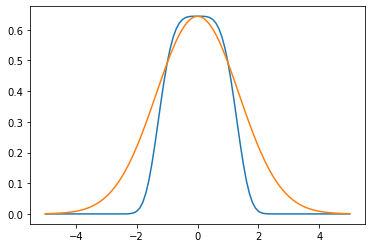

In [149]:
# plot the orbital/density

rs = np.linspace(-5, 5, 101)
phis = [orbital_1s_1D(ri, R1[0]) for ri in rs]
rhos = [orbital_1s_1D(ri**2, R1[0]) for ri in rs]

plt.plot(rs, rhos)
plt.plot(rs, phis)

In [150]:
# test simple integration
np.sum(rhos) * (rs[1] - rs[0])

1.619276861531746

In [151]:
# test MC integration on a simple function

def test_mc_integration():
    np.random.seed(42)
    
    @jit(nopython=True)
    def func(x):
        # return x**9
        return np.exp(-x**2) / np.sqrt(np.pi)

    n_pts = 20_000
    # x_min, x_max = 0., 1.
    x_min, x_max = -3., 3.
    V = x_max - x_min

    pts = np.random.uniform(x_min, x_max, size=(n_pts))

    I = 0.0
    for pt in pts:
        I += func(pt)

    I *= V / n_pts
    return I

test_mc_integration()

1.008719304817534

In [153]:
# test orbital density MC integration in 1d
np.random.seed(42)
r_min, r_max = -5.0, 5.0
V_single = r_max - r_min

n_pts = 20_000
pts = np.random.uniform(r_min, r_max, size=(n_pts,))

I = 0.0
for pt in pts:
    I += orbital_1s_1D(pt, R1[0])**2 # density

I *= V_single / n_pts
I

1.0113250890220704

In [155]:
# test orbital density MC integration in 3d
np.random.seed(42)
r_min, r_max = -5.0, 5.0
V_single = (r_max - r_min)**3

n_pts = 50_000
pts = np.random.uniform(r_min, r_max, size=(n_pts, 3))

I = 0.0
for pt in pts:
    I += orbital_1s(pt, R1)**2 # density

I *= V_single / n_pts
I

0.9945444272799734

## Compute fixed matrices

In [161]:
# generate random points
np.random.seed(42)
n_pts = 50_000
r_min, r_max = -6.0, 7.5
V_single = (r_max - r_min)**3
pts = np.random.uniform(r_min, r_max, size=(n_pts, 3))

pts1 = pts
pts2 = np.random.uniform(r_min, r_max, size=(n_pts, 3))
V_double = (r_max - r_min)**6

In [166]:
@jit(nopython=True)
def overlap_integrals(R1, R2, pts1, pts2):

    # FILL
    I1 = 0.0
    for r1, r2 in zip(pts1, pts2):
        r12 = (r1 - r2) @ (r1 - r2)
        I1 += orbital_1s(r1, R1)**2 * orbital_1s(r2, R2)**2 / r12
        
    I1 *= V_double / n_pts
    
    
    mat = np.zeros(size=(2, 2, 2, 2))
    # FILL mat elements
    
    return mat


def kinetic_energy():
    pass


@jit(nopython=True)
def nuclear_energy_term(R1, R2, Z1, Z2, pts):
    """Compute V_nucl"""
    V11 = 0.0
    for r in pts:
        central_term = - Z1 / norm(r - R1) - Z2 / norm(r - R2)
        V11 += orbital_1s(r, R1) * orbital_1s(r, R1) * central_term
        
    V11 *= V_single / n_pts
    
    V22 = 0.0
    for r in pts:
        central_term = - Z1 / norm(r - R1) - Z2 / norm(r - R2)
        V22 += orbital_1s(r, R2) * orbital_1s(r, R2) * central_term
        
    V22 *= V_single / n_pts
        
    V12 = 0.0
    for r in pts:
        central_term = - Z1 / norm(r - R1) - Z2 / norm(r - R2)
        V12 += orbital_1s(r, R1) * orbital_1s(r, R2) * central_term
        
    V12 *= V_single / n_pts
    
    mat = np.array([[V11, V12], [V12, V22]])
    return mat


@jit(nopython=True)
def overlap_matrix(R1, R2, pts):
    """Compute Sij"""
    def func(r):
        # return (orbital_1s(r, R1) + orbital_1s(r, R2)) / np.sqrt(2.0)
        return orbital_1s(r, R1) * orbital_1s(r, R2)
    
    # s = compute_single_integral(orbital_1s, orbital_1s, R1, R2, pts)
    s = 0.0
    n_pts = len(pts)
    for r in pts:
        s += func(r)
    
    s *= V_single / n_pts
    
    S = np.array([[1.0, s], [s, 1.0]])
    return S

In [160]:
%%time

overlap_matrix(R1, R2, pts)

CPU times: user 596 ms, sys: 23.4 ms, total: 619 ms
Wall time: 626 ms


array([[1.        , 0.85676442],
       [0.85676442, 1.        ]])

In [167]:
%%time

nuclear_energy_term(R1, R2, Z1, Z2, pts)

CPU times: user 1.09 s, sys: 37.9 ms, total: 1.13 s
Wall time: 1.14 s


array([[-1.47593502, -1.33821354],
       [-1.33821354, -1.48520007]])

In [ ]:
# simulation parameters
n_pts = 1_000_000

n_cycles = 10

In [6]:

def density_matrix():
    pass

def g_matrix():
    pass

def calculate_hf_step():
    pass